In [3]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [2]:
!pip install -U scikit-image
!pip install torch
!pip install matplotlib
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print("torch version: ", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("device: ", device)

torch version:  2.5.1+cu124
device:  cpu


# Camera / Dataset

In [ ]:
batch_size = 1024

o, d, target_px_values = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

# Training

100%|███████████████████████████████████████| 3516/3516 [25:51<00:00,  2.27it/s]


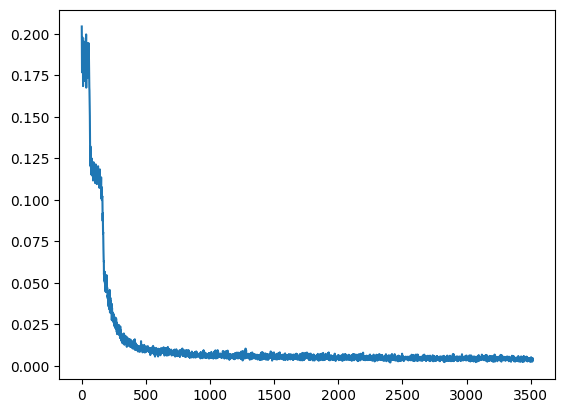

  2%|▋                                    | 268/14063 [01:59<1:40:28,  2.29it/s]

In [ ]:
device = device

tn = 8.
tf = 12.
nb_epochs = 30 #15
lr = 5e-4 #1e-3
gamma = 0.7 #.5
nb_bins = 256 #100

model = Nerf(hidden_dim=256).to(device) #Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [ ]:
torch.save(model, 'model_nerf_mps')

# Testing

# Mesh extraction

In [ ]:
model = torch.load('model_nerf_mps').to(device)

In [ ]:
N = 100 #100
scale = 1.5

x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)

x, y, z = torch.meshgrid((x, y, z))

In [ ]:
xyz = torch.cat((x.reshape(-1, 1),
                 y.reshape(-1, 1),
                 z.reshape(-1, 1)), dim=1)

In [ ]:
with torch.no_grad():
    _, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))

density = density.cpu().numpy().reshape(N, N, N)

In [ ]:
#!pip install Pymcubes
#!pip install trimesh
#!pip install -U scikit-image
#!pip install genesis-world  # Requires Python >=3.9;
#!pip install genesis-world
#!conda install -c anaconda trimesh

In [ ]:
import numpy as np
from skimage.measure import marching_cubes

# marching_cubes returns: vertices, faces, normals, values
vertices, faces, normals, values = marching_cubes(density, level=15 * np.mean(density))

In [ ]:
import numpy as np
import trimesh

In [ ]:
mesh = trimesh.Trimesh(vertices=vertices / N, faces=faces)

In [ ]:
mesh.show()

In [ ]:
mesh.export('my_mesh.obj')  # .stl, .ply, etc.

# Color mesh 1

In [ ]:
mesh.compute_vertex_normals()

In [ ]:
import torch
import numpy as np
from skimage.measure import marching_cubes
import trimesh
import trimesh.smoothing

def generate_detailed_mesh(model, device, N=200, scale=1.5, batch_size=50000, density_threshold=None):
    """
    Generate a detailed mesh from a NeRF model using batched processing.

    Args:
        model: The trained NeRF model
        device: torch device
        N: Number of points per dimension
        scale: Scene scale
        batch_size: Number of points to process at once
        density_threshold: Threshold for marching cubes (if None, uses mean-based threshold)
    """
    # Generate grid points
    x = torch.linspace(-scale, scale, N)
    y = torch.linspace(-scale, scale, N)
    z = torch.linspace(-scale, scale, N)
    x, y, z = torch.meshgrid((x, y, z), indexing='ij')
    xyz = torch.stack([x, y, z], dim=-1).reshape(-1, 3)

    # Process in batches to avoid memory issues
    densities = []
    for i in range(0, xyz.shape[0], batch_size):
        batch_xyz = xyz[i:i+batch_size].to(device)
        batch_dirs = torch.zeros_like(batch_xyz).to(device)

        with torch.no_grad():
            # Assuming model.forward returns (rgb, density)
            _, batch_density = model.forward(batch_xyz, batch_dirs)
            densities.append(batch_density.cpu())

    # Combine results
    density = torch.cat(densities, dim=0).numpy().reshape(N, N, N)

    # Determine threshold
    if density_threshold is None:
        density_threshold = 30 * np.mean(density)

    # Generate mesh using marching cubes
    vertices, faces, normals, values = marching_cubes(
        density,
        level=density_threshold,
        spacing=(scale*2/N, scale*2/N, scale*2/N)
    )

    # Create and clean mesh
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, normals=normals)

    # Optional: Remove disconnected components
    components = mesh.split(only_watertight=False)
    if len(components) > 1:
        # Keep the largest component
        areas = np.array([c.area for c in components])
        mesh = components[np.argmax(areas)]

    # Smooth the mesh
    mesh = trimesh.smoothing.filter_laplacian(mesh)

    # Flip the normals by inverting faces
    mesh.invert()

    return mesh

# Usage example:
N = 250  # Increased resolution
scale = 1.5
mesh = generate_detailed_mesh(model, device, N=N, scale=scale)

# Display the mesh
mesh.show()

In [ ]:
#mesh.export('mesh.obj')  # .stl, .ply, etc.

In [ ]:
!pip install --upgrade PyMCubes